# kNN Classification


K最近邻(k-Nearest Neighbor，kNN)分类算法，是一个理论上比较成熟的方法，也是最简单的机器学习算法之一。该方法的思路是：***如果一个样本在特征空间中的k个最相似（即特征空间中最邻近）的样本中的大多数属于某一个类别，则该样本也属于这个类别***。kNN方法虽然从原理上也依赖于[极限定理](https://baike.baidu.com/item/%E6%9E%81%E9%99%90%E5%AE%9A%E7%90%86/13672616)，但在类别决策时，只与极少量的相邻样本有关。由于kNN方法主要靠周围有限的邻近的样本，而不是靠判别类域的方法来确定所属类别的，因此对于类域的交叉或重叠较多的待分样本集来说，kNN方法较其他方法更为适合。

kNN算法不仅可以用于分类，还可以用于回归。通过找出一个样本的`k`个最近邻居，将这些邻居的属性的平均值赋给该样本，就可以得到该样本的属性。更有用的方法是将不同距离的邻居对该样本产生的影响给予不同的权值(weight)，如权值与距离成正比（组合函数）。

该算法存在的问题：
1. 当样本不平衡时，如一个类的样本容量很大，而其他类样本容量很小时，有可能导致当输入一个新样本时，该样本的K个邻居中大容量类的样本占多数。在这种情况下可能会产生误判的结果。因此我们需要减少数量对运行结果的影响。可以采用权值的方法（和该样本距离小的邻居权值大）来改进。
2. 计算量较大，因为对每一个待分类的数据都要计算它到全体已知样本的距离，才能求得它的K个最近邻点。目前常用的解决方法是事先对已知样本点进行剪辑，事先去除对分类作用不大的样本。该算法比较适用于样本容量比较大的类域的自动分类，而那些样本容量较小的类域采用这种算法比较容易产生误分。

kNN可以说是一种最直接的用来分类未知数据的方法。基本通过下面这张图跟文字说明就可以明白kNN是干什么的
![knn](images/knn.png)

简单来说，kNN可以看成：**有那么一堆你已经知道分类的数据，然后当一个新数据进入的时候，就开始跟训练数据里的每个点求距离，然后挑选这个训练数据最近的K个点，看看这几个点属于什么类型，然后用少数服从多数的原则，给新数据归类**。


## 1. 算法步骤：

1. 准备数据，对数据进行预处理;
2. 计算测试数据与各个训练数据之间的**距离**；
3. 按照距离的递增关系进行排序；
4. 选取距离最小的`k`个点；
5. 确定前`k`个点所在类别的出现频率；
6. 返回前`k`个点中出现频率最高的类别作为测试数据的预测分类。

上述的处理过程，难点有哪些？

## 2. 生成数据

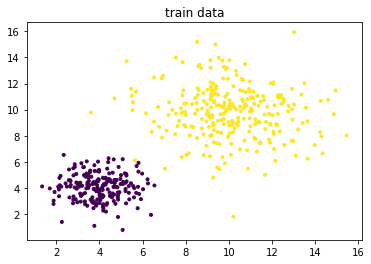

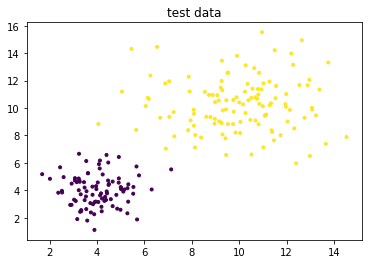

In [7]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# data generation
np.random.seed(314)

data_size1 = 300
x1 = np.random.randn(data_size1, 2) + np.array([4,4])
y1 = [0 for _ in range(data_size1)]

data_size2 = 400
x2 = np.random.randn(data_size2, 2)*2 + np.array([10,10])
y2 = [1 for _ in range(data_size2)]


# all sample data
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((y1, y2), axis=0)

data_size_all = data_size1 + data_size2
shuffled_index = np.random.permutation(data_size_all)
x = x[shuffled_index]
y = y[shuffled_index]

# split train & test
split_index = int(data_size_all*0.7)
x_train = x[:split_index]
y_train = y[:split_index]
x_test = x[split_index:]
y_test = y[split_index:]


# plot data
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='.')
plt.title("train data")
plt.show()
plt.scatter(x_test[:,0], x_test[:,1], c=y_test, marker='.')
plt.title("test data")
plt.show()


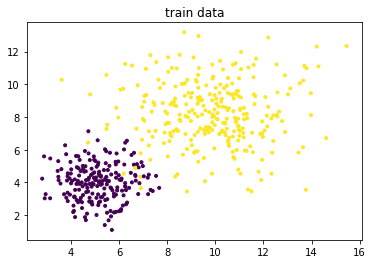

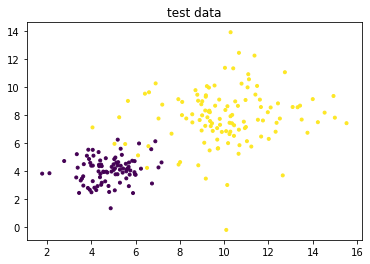

In [12]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# data generation
np.random.seed(314)
data_size_1 = 300

x1_1 = np.random.normal(loc=5.0, scale=1.0, size=data_size_1)
x2_1 = np.random.normal(loc=4.0, scale=1.0, size=data_size_1)
y_1 = [0 for _ in range(data_size_1)]

data_size_2 = 400
x1_2 = np.random.normal(loc=10.0, scale=2.0, size=data_size_2)
x2_2 = np.random.normal(loc=8.0, scale=2.0, size=data_size_2)
y_2 = [1 for _ in range(data_size_2)]

x1 = np.concatenate((x1_1, x1_2), axis=0)
x2 = np.concatenate((x2_1, x2_2), axis=0)
x = np.hstack((x1.reshape(-1,1), x2.reshape(-1,1)))
y = np.concatenate((y_1, y_2), axis=0)

data_size_all = data_size_1+data_size_2
shuffled_index = np.random.permutation(data_size_all)
x = x[shuffled_index]
y = y[shuffled_index]

split_index = int(data_size_all*0.7)
x_train = x[:split_index]
y_train = y[:split_index]
x_test = x[split_index:]
y_test = y[split_index:]


# visualize data
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='.')
plt.title("train data")
plt.show()
plt.scatter(x_test[:,0], x_test[:,1], c=y_test, marker='.')
plt.title("test data")
plt.show()


## 3. 最简单的程序实现

In [14]:
import numpy as np
import operator

def knn_distance(v1, v2):
    return np.sum(np.square(v1-v2))

def knn_vote(ys):
    vote_dict = {}
    
    maxv = 0
    maxk = 0
    for y in ys:
        if y not in vote_dict.keys():
            vote_dict[y] = 1
        else:
            vote_dict[y] += 1
        if maxv < vote_dict[y]:
            maxv = vote_dict[y]
            maxk = y
    return maxk

    sorted_vote_dict = sorted(vote_dict.items(), \
                              #key=operator.itemgetter(1), \
                              key=lambda x:x[1], \
                              reverse=True)
    return sorted_vote_dict[0][0]
    
def knn_predict(x, train_x, train_y, k=3):
    dist_arr = [knn_distance(x, train_x[j]) for j in range(len(train_x))]
    sorted_index = np.argsort(dist_arr)
    top_k_index = sorted_index[:k]
    ys=train_y[top_k_index]
    return knn_vote(ys)
    

#a = knn_predict(x_train[0], x_train, y_train)

y_train_est = [knn_predict(x_train[i], x_train, y_train) for i in range(len(x_train))]
print(y_train_est)

[0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 

In [6]:
n_correct = 0
for i in range(len(x_train)):
    if y_train_est[i] == y_train[i]:
        n_correct += 1
accuracy = n_correct / len(x_train) * 100.0
print("Train Accuracy: %f%%" % accuracy)

Train Accuracy: 98.568507%


In [7]:
y_test_est = [knn_predict(x_test[i], x_train, y_train, 3) for i in range(len(x_test))]
n_correct = 0
for i in range(len(x_test)):
    if y_test_est[i] == y_test[i]:
        n_correct += 1
accuracy = n_correct / len(x_test) * 100.0
print("Test Accuracy: %f%%" % accuracy)

Test Accuracy: 96.682464%


## 4. 通过类实现kNN程序

In [9]:
import numpy as np
import operator

class KNN(object):

    def __init__(self, k=3):
        self.k = k

    def fit(self, x, y):
        self.x = x
        self.y = y
        return self

    def _square_distance(self, v1, v2):
        return np.sum(np.square(v1-v2))

    def _vote(self, ys):
        ys_unique = np.unique(ys)
        vote_dict = {}
        for y in ys:
            if y not in vote_dict.keys():
                vote_dict[y] = 1
            else:
                vote_dict[y] += 1
        sorted_vote_dict = sorted(vote_dict.items(), key=operator.itemgetter(1), reverse=True)
        return sorted_vote_dict[0][0]

    def predict(self, x):
        y_pred = []
        for i in range(len(x)):
            dist_arr = [self._square_distance(x[i], self.x[j]) for j in range(len(self.x))]
            sorted_index = np.argsort(dist_arr)
            top_k_index = sorted_index[:self.k]
            y_pred.append(self._vote(ys=self.y[top_k_index]))
        return np.array(y_pred)

    def score(self, y_true=None, y_pred=None):
        if y_true is None and y_pred is None:
            y_pred = self.predict(self.x)
            y_true = self.y
        score = 0.0
        for i in range(len(y_true)):
            if y_true[i] == y_pred[i]:
                score += 1
        score /= len(y_true)
        return score

In [13]:
# data preprocessing
#x_train = (x_train - np.min(x_train, axis=0)) / (np.max(x_train, axis=0) - np.min(x_train, axis=0))
#x_test = (x_test - np.min(x_test, axis=0)) / (np.max(x_test, axis=0) - np.min(x_test, axis=0))

# knn classifier
clf = KNN(k=3)
train_acc = clf.fit(x_train, y_train).score() * 100.0

y_test_pred = clf.predict(x_test)
test_acc = clf.score(y_test, y_test_pred) * 100.0

print('train accuracy: %f %%' % train_acc)
print('test accuracy: %f %%' % test_acc)

train accuracy: 98.568507 %
test accuracy: 96.682464 %


## 5. sklearn program

In [6]:
#% matplotlib inline

import matplotlib.pyplot as plt
from sklearn import datasets, neighbors, linear_model

# load data
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

print("Feature dimensions: ", X_digits.shape)
print("Label dimensions:   ", y_digits.shape)


Feature dimensions:  (1797, 64)
Label dimensions:    (1797,)


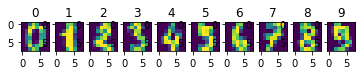

In [7]:
# plot sample images
nplot = 10
fig, axes = plt.subplots(nrows=1, ncols=nplot)

for i in range(nplot):
    img = X_digits[i].reshape(8, 8)
    axes[i].imshow(img)
    axes[i].set_title(y_digits[i])


In [8]:
# split train / test data
n_samples = len(X_digits)
n_train = int(0.4 * n_samples)

X_train = X_digits[:n_train]
y_train = y_digits[:n_train]
X_test = X_digits[n_train:]
y_test = y_digits[n_train:]


In [10]:
# do KNN classification
knn = neighbors.KNeighborsClassifier()
logistic = linear_model.LogisticRegression()

print('KNN score: %f' % knn.fit(X_train, y_train).score(X_test, y_test))
print('LogisticRegression score: %f' % logistic.fit(X_train, y_train).score(X_test, y_test))

KNN score: 0.953661
LogisticRegression score: 0.927711


/home/bushuhui/anaconda3/envs/dl/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## 6. 深入思考

* 如果输入的数据非常多，怎么快速进行距离计算？
    - [kd-tree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree) 
    - Fast Library for Approximate Nearest Neighbors （FLANN）
    - [PyNNDescent for fast Approximate Nearest Neighbors](https://pynndescent.readthedocs.io/en/latest/)
* 如何选择最好的`k`？
    - https://zhuanlan.zhihu.com/p/143092725
* kNN存在的问题？

## References
* [Digits Classification Exercise](http://scikit-learn.org/stable/auto_examples/exercises/plot_digits_classification_exercise.html)
* [knn算法的原理与实现](https://zhuanlan.zhihu.com/p/36549000)